In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [4]:
# đọc dữ liệu
df = pd.read_csv('wti_prices.csv')
df

,date,open,high,low,close,volume,average
0,2024-04-04,75.90,76.71,75.44,76.46,4467.0,76.149
1,2024-04-05,76.54,76.91,76.23,76.41,3429.0,76.552
2,2024-04-08,76.57,76.74,75.54,76.18,2276.0,76.070
3,2024-04-09,76.42,76.52,75.48,75.63,1811.0,75.900
4,2024-04-10,76.01,76.48,75.45,76.27,3500.0,76.077
...,...,...,...,...,...,...,...
2076,2017-03-30,54.95,54.95,54.95,54.95,0.0,54.950
2077,2017-03-31,55.44,55.44,55.44,55.44,0.0,55.440
2078,2017-04-03,55.83,55.83,55.83,55.83,0.0,55.830
2079,2017-04-04,56.18,56.18,56.18,56.18,0.0,56.180


In [5]:
print('5 dòng đầu tiên của tập dữ liệu:')
display(df.head())


5 dòng đầu tiên của tập dữ liệu:


,date,open,high,low,close,volume,average
0,2024-04-04,75.90,76.71,75.44,76.46,4467.0,76.149
1,2024-04-05,76.54,76.91,76.23,76.41,3429.0,76.552
2,2024-04-08,76.57,76.74,75.54,76.18,2276.0,76.070
3,2024-04-09,76.42,76.52,75.48,75.63,1811.0,75.900
4,2024-04-10,76.01,76.48,75.45,76.27,3500.0,76.077


In [6]:
print('\nThông tin tập dữ liệu:')
df.info()


Thông tin tập dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     2081 non-null   object 
 1   open     2081 non-null   float64
 2   high     2081 non-null   float64
 3   low      2081 non-null   float64
 4   close    2081 non-null   float64
 5   volume   2081 non-null   float64
 6   average  2081 non-null   float64
dtypes: float64(6), object(1)
memory usage: 113.9+ KB


In [7]:
df.duplicated().sum()

3

In [8]:
df = df.drop_duplicates()

Sau khi tải dữ liệu, chúng ta cần tiến hành tiền xử lý để chuẩn bị cho mô hình CNN. Các bước tiếp theo sẽ bao gồm:

1.  **Kiểm tra và xử lý cột thời gian**: Đảm bảo cột thời gian được định dạng đúng và có thể được sử dụng để tạo chuỗi thời gian.
2.  **Chuẩn hóa dữ liệu**: Scale các giá trị số để mô hình hoạt động tốt hơn.
3.  **Tạo chuỗi (sequences) cho CNN**: Chuyển đổi dữ liệu chuỗi thời gian thành các chuỗi đầu vào và đầu ra phù hợp với kiến trúc CNN (ví dụ: sử dụng cửa sổ trượt).
4.  **Chia dữ liệu thành tập huấn luyện và kiểm tra**.

## Chuyển đổi cột thời gian

### Subtask:
Chuyển đổi cột 'date' sang định dạng datetime và đặt nó làm chỉ mục (index) của DataFrame để thuận tiện cho việc xử lý chuỗi thời gian.


In [12]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2078 entries, 2024-04-04 to 2017-04-05
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     2078 non-null   float64
 1   high     2078 non-null   float64
 2   low      2078 non-null   float64
 3   close    2078 non-null   float64
 4   volume   2078 non-null   float64
 5   average  2078 non-null   float64
dtypes: float64(6)
memory usage: 113.6 KB


C:\Users\huyh2\AppData\Local\Temp\ipykernel_16472\4097426248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [13]:
# Sắp xếp lại các dòng dữ liệu
df_wti = df.sort_index()
df_wti = df_wti.resample('D').asfreq()
df_wti = df_wti.interpolate()

print(df_wti.index.dtype)
print(df_wti.info())

df_wti

datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054 entries, 2016-11-23 to 2025-04-03
Freq: D
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     3054 non-null   float64
 1   high     3054 non-null   float64
 2   low      3054 non-null   float64
 3   close    3054 non-null   float64
 4   volume   3054 non-null   float64
 5   average  3054 non-null   float64
dtypes: float64(6)
memory usage: 167.0 KB
None


,open,high,low,close,volume,average
date,,,,,,
2016-11-23,58.660000,58.660000,58.660000,58.660000,0.000000,58.660000
2016-11-24,57.990000,57.990000,57.990000,57.990000,0.000000,57.990000
2016-11-25,57.320000,57.320000,57.320000,57.320000,0.000000,57.320000
2016-11-26,57.496667,57.496667,57.496667,57.496667,0.000000,57.496667
2016-11-27,57.673333,57.673333,57.673333,57.673333,0.000000,57.673333
...,...,...,...,...,...,...
2025-03-30,69.336667,70.613333,68.846667,70.113333,30596.666667,69.982667
2025-03-31,69.330000,71.240000,69.060000,70.870000,35933.000000,70.542000
2025-04-01,71.150000,71.520000,70.580000,70.690000,27070.000000,70.946000


In [14]:
# Chọn cột 'close' làm cột mục tiêu
data = df_wti[['close']]
data

,close
date,
2016-11-23,58.660000
2016-11-24,57.990000
2016-11-25,57.320000
2016-11-26,57.496667
2016-11-27,57.673333
...,...
2025-03-30,70.113333
2025-03-31,70.870000
2025-04-01,70.690000


<Axes: xlabel='date'>

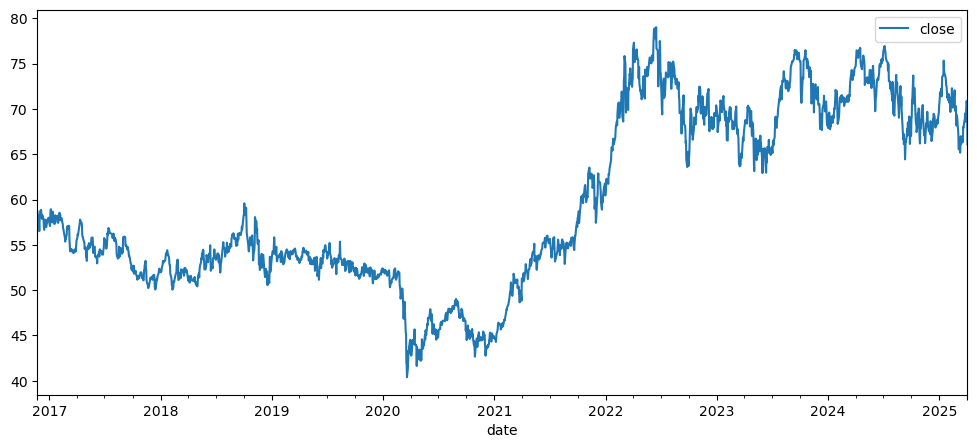

In [15]:
data.plot(figsize=(12,5))

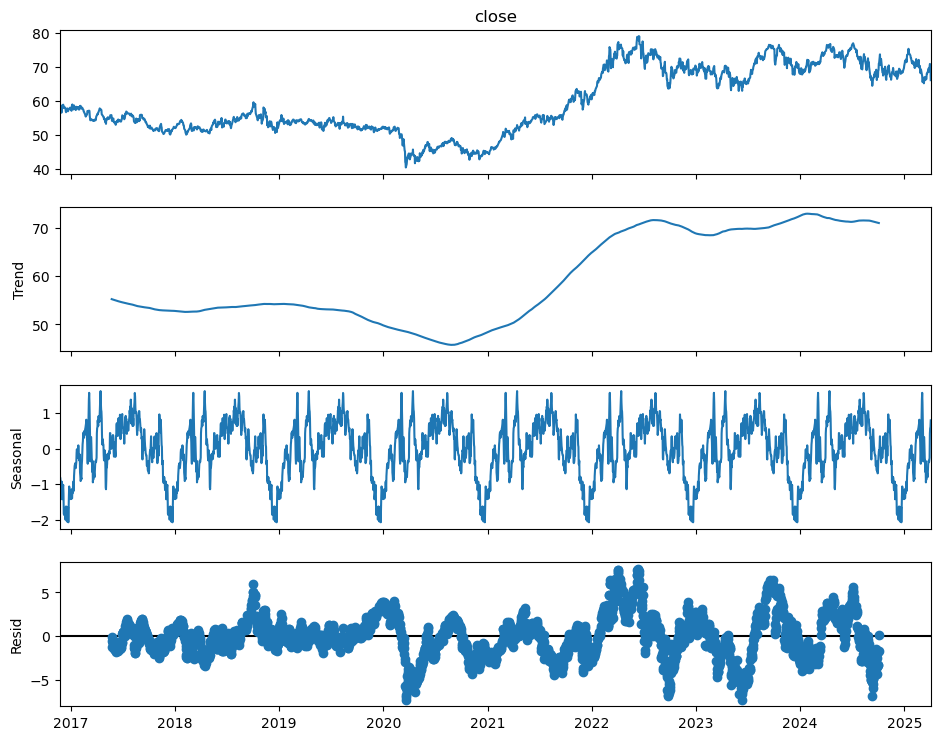

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['close'], model='additive', period=365)

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

In [17]:
# Chuẩn hóa dữ liệu trong khoảng [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [18]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

# Định nghĩa số bước nhìn lại (look-back steps)
n_steps = 10 # Sử dụng 10 ngày trước đó để dự đoán ngày tiếp theo

X, y = create_sequences(scaled_data, n_steps)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# Chúng ta sẽ giữ 80% dữ liệu để huấn luyện và 20% để kiểm tra
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape dữ liệu cho mô hình CNN (Conv1D) - cần định dạng (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_test: {y_test.shape}")

Kích thước X_train: (2435, 10, 1)
Kích thước y_train: (2435,)
Kích thước X_test: (609, 10, 1)
Kích thước y_test: (609,)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Xây dựng mô hình CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# In tóm tắt mô hình
model.summary()

C:\Users\huyh2\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 9, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          12,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,093 (51.14 KB)

 Trainable params: 13,093 (51.14 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

print("Mô hình đã được huấn luyện!")

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0435 - val_loss: 0.0017
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1684e-04 - val_loss: 0.0021
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8628e-04 - val_loss: 0.0016
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9815e-04 - val_loss: 0.0015
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8626e-04 - val_loss: 0.0018
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0737e-04 - val_loss: 0.0017
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3064e-04 - val_loss: 0.0017
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3175e-04 - val_loss: 0.0014
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1073e-04 - val_loss: 0.0013
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8511e-04 - val_loss: 0.0012
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2028e-04 - val_loss: 0.0012
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Thực hiện dự đoán trên tập kiểm tra
y_pred_scaled = model.predict(X_test)

# Đảo ngược chuẩn hóa để có được giá trị gốc
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred_scaled)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [22]:
#Tính toán các chỉ số đánh giá
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"RMSE (Root Mean Squared Error) trên tập kiểm tra: {rmse:.2f}")
print(f"MAE (Mean Absolute Error) trên tập kiểm tra: {mae:.2f}")

RMSE (Root Mean Squared Error) trên tập kiểm tra: 1.05
MAE (Mean Absolute Error) trên tập kiểm tra: 0.82


In [23]:
len(y_pred_actual)

609

In [24]:
test = data.iloc[-609:]

test

,close
date,
2023-08-04,73.100000
2023-08-05,73.066667
2023-08-06,73.033333
2023-08-07,73.000000
2023-08-08,73.600000
...,...
2025-03-30,70.113333
2025-03-31,70.870000
2025-04-01,70.690000


In [25]:
test['pred'] = y_pred_actual
test

C:\Users\huyh2\AppData\Local\Temp\ipykernel_16472\2353440712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = y_pred_actual


,close,pred
date,,
2023-08-04,73.100000,71.131485
2023-08-05,73.066667,71.272179
2023-08-06,73.033333,72.937653
2023-08-07,73.000000,72.706711
2023-08-08,73.600000,72.714622
...,...,...
2025-03-30,70.113333,68.473648
2025-03-31,70.870000,68.557678
2025-04-01,70.690000,69.776253


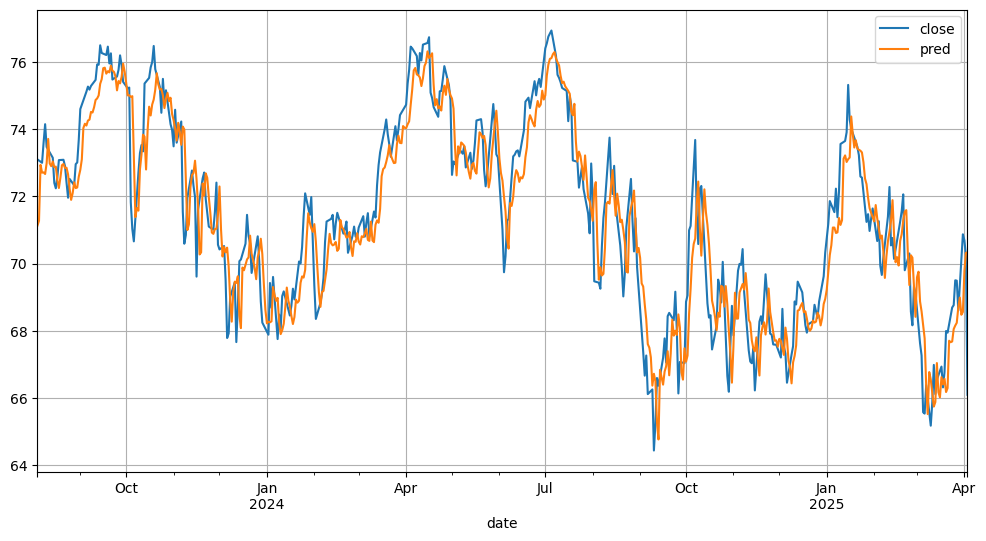

In [26]:
test.plot(figsize=(12,6))
plt.grid(ls='-')
plt.show()